## **Imports**

In [1]:
USING_COLAB = True
ADD_NEW_FEATURES = True

In [3]:
if USING_COLAB:
  %pip install catboost xgboost lightgbm tsfresh shap optuna -q

  # loading data
  !gdown 1_RQxjVFlve12NMTSyvEWlL6m9eylHmxU
  !gdown 12NVI9hbSnFjfiT27d-FkaeLmkz3WgvwI
  !gdown 1jkpplWIKV6IS7AHBPEPcgmiQC8T6RuuJ
  !gdown 1V9X-iDGABK0njxTm6nVJPDH-cquHqJ8s
  !gdown 1fXx465_ICgmZ1-9_Sl45w7GHLHzndyRo

Downloading...
From: https://drive.google.com/uc?id=1_RQxjVFlve12NMTSyvEWlL6m9eylHmxU
To: /content/graph.csv
100% 5.75M/5.75M [00:00<00:00, 184MB/s]
Downloading...
From: https://drive.google.com/uc?id=12NVI9hbSnFjfiT27d-FkaeLmkz3WgvwI
To: /content/submission.csv
100% 131k/131k [00:00<00:00, 81.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1jkpplWIKV6IS7AHBPEPcgmiQC8T6RuuJ
To: /content/test2_X.csv
100% 40.0M/40.0M [00:00<00:00, 91.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1V9X-iDGABK0njxTm6nVJPDH-cquHqJ8s
To: /content/train_X.csv
100% 87.8M/87.8M [00:00<00:00, 156MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fXx465_ICgmZ1-9_Sl45w7GHLHzndyRo
To: /content/train_y.csv
100% 514k/514k [00:00<00:00, 120MB/s]


In [4]:
# Other tools
import pickle
import random
import os

from collections import Counter
from tqdm import tqdm
from copy import deepcopy

# Train
from sklearn.model_selection import KFold, StratifiedGroupKFold, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Visual
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Preprocessing
import pandas as pd
import numpy as np

from datetime import datetime
from imblearn.over_sampling import SMOTE

# Model
import lightgbm as lgb
import xgboost as xgb

from catboost import CatBoostClassifier, Pool
from sklearn.tree import DecisionTreeClassifier

def gini(y_true, y_pred):
    return 2 * roc_auc_score(y_true, y_pred) - 1

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [5]:
# Session settings
pd.set_option('display.max_rows', 15)

plt.rcParams['font.weight'] = 'semibold'
plt.rcParams['figure.figsize'] = 14, 8
plt.rcParams['font.size'] = 18
plt.rcParams['savefig.format'] = 'pdf'

# make results reproducable
def set_seed(seed=42):
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(SEED)

SEED = 69
set_seed(SEED)

## **OLD Preprocessing**

## **New preprocessing function**

In [6]:
def preprocess_data(
    train,
    test,
    delete_corr_features=True,
    scale=True,
    init_features2drop=None,
    cat_features=[]
  ):

    constant_features_names = ['agg_BoardOfDirectors__g_contractor__Name__count__ALL_TIME', 'agg_ConsolidatedIndicator__g_contractor__Index__IndexOfDueDiligence__mean__ALL_TIME', 'agg_spark_extended_report__g_contractor__CreditLimitSum__last__ALL_TIME', 'agg_ConsolidatedIndicator__g_contractor__Index__Overall__mean__ALL_TIME', 'agg_ConsolidatedIndicator__g_contractor__Index__PaymentIndex__mean__ALL_TIME', 'agg_spark_extended_report__g_contractor__CompanySizeRevenue__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__PledgeeActiveCount__last__ALL_TIME', 'contract_date', 'contract_init_sum', 'agg_spark_extended_report__g_contractor__PledgerActiveCount__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__PledgeeCeasedCount__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__PledgerCeasedCount__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__EstimatedNetLiabilitiesSum__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__EstimatedClaimsSum__last__ALL_TIME', 'agg_spark_extended_report__g_contractor__EstimatedLiabilitiesSum__last__ALL_TIME', 'agg_ConsolidatedIndicator__g_contractor__Index__FailureScore__mean__ALL_TIME']

    if delete_corr_features:
        train = train.drop(columns=ts_features2drop)
        test = test.drop(columns=ts_features2drop)

    # for now lets drop columns where num of nans is greater that  a half of df length
    isna_stat = train.isna().sum()[train.isna().sum() > 0]
    features2drop = [col for col in isna_stat.index if isna_stat[col] > (train.shape[0] * (3/4))]
    train.drop(columns=features2drop, inplace=True)
    test.drop(columns=features2drop, inplace=True)

    # other we`ll fill with median
    for col in isna_stat.index:
        if col not in features2drop:
            train_imputer = SimpleImputer(strategy="median").fit(train[col].values.reshape(-1, 1))
            train[col] = train_imputer.transform(train[col].values.reshape(-1, 1))
            test[col] = train_imputer.transform(test[col].values.reshape(-1, 1))

    #translate to timestamp
    dates_columns = train.select_dtypes('object').columns

    new_dates_cols = []

    for date_col in dates_columns:
        train[f"{date_col}_day"] = train[date_col].apply(lambda x: datetime.fromisoformat(x).day)
        train[f"{date_col}_month"] = train[date_col].apply(lambda x: datetime.fromisoformat(x).month)

        test[f"{date_col}_day"] = test[date_col].apply(lambda x: datetime.fromisoformat(x).day)
        test[f"{date_col}_month"] = test[date_col].apply(lambda x: datetime.fromisoformat(x).month)

        train[date_col] = train[date_col].apply(lambda x: datetime.fromisoformat(x).timestamp())
        test[date_col] = test[date_col].apply(lambda x: datetime.fromisoformat(x).timestamp())

        new_dates_cols.extend([f"{date_col}_day", f"{date_col}_month"])

    if init_features2drop is not None:
      train = train.drop(columns=init_features2drop)
      test = test.drop(columns=init_features2drop)

    return train, test, constant_features_names

## **Loading and preprocess data**

In [168]:
if not USING_COLAB:
  root_data_path = "data"
else:
  root_data_path = "/content"

X_train = pd.read_csv(f"{root_data_path}/train_X.csv")
y_train_all = pd.read_csv(f"{root_data_path}/train_y.csv")

train = X_train.merge(y_train_all, on=["contract_id", "report_date"], how="left")
test = pd.read_csv(f"{root_data_path}/test2_X.csv")

y_train_all = train["default6"]
train_orig = deepcopy(train)

In [169]:
for_drop = ["project_id", "building_id", "contractor_id", "specialization_id"]
cat_features = [ "report_date_day", "report_date_month", "contract_date_day", "contract_date_month"]

train, test, constant_features_names = preprocess_data(
    train.copy(),
    test.copy(),
    delete_corr_features=False,
    scale=False,
    init_features2drop=for_drop,
)

In [170]:
# train = train.drop(columns=for_drop).fillna(0)
# test = test.drop(columns=for_drop).fillna(0)

In [171]:
contracts = train.sort_values('report_date').groupby("contract_id")

batches = [[] for i in range(30)]


for c_id in tqdm(train["contract_id"].unique()):
  contract = contracts.get_group(c_id).sample(frac=1).reset_index(drop=True)
  for i in range(30):
    if i >= len(contract): break
    else:
      # if i != 0:
      #   contract.loc[i, "pred_target"] = contract.loc[i - 1, "default6"]
      batches[i].append(contract.loc[i])

100%|██████████| 3448/3448 [00:17<00:00, 197.80it/s]


In [172]:
for i in range(30):
  print(len(batches[i]))

3448
3077
2735
2393
2102
1856
1645
1456
1291
1143
1009
902
793
696
608
520
454
401
344
303
261
230
200
185
169
152
139
117
105
97


<div class="alert alert-info">
    
**Режимы построения дерева (политика роста)**
    
`grow_policy` – определяет, как будет применяться жадный алгоритм поиска. Может стоять в значении **`SymmetricTree`**, **`Depthwise`** или **`Lossguide`**. По умолчанию **`SymmetricTree`**.
  * **`SymmetricTree`** - дерево строится уровень за уровнем, пока не достигнет необходимой глубины. На каждом шаге листья с предыдущего дерева разделяются с тем же условием.
  * **`Depthwise`** дерево строится шаг за шагом, пока не достигнет необходимой глубины. Листья разделяются с использованием условия, которое приводит к лучшему уменьшению потерь.
  * **`Lossguide`** дерево строится по листьям до тех пор, пока не будет достигнуто заданное количество листьев. На каждом шаге разделяется нетерминальный лист с лучшим уменьшением потерь. lightGBM
    

**Напоминание:**

* `min_data_in_leaf` или `min_child_samples` – это минимальное количество обучающих сэмплов в листе. Этот параметр используется только с политиками роста **`Lossguide`** и **`Depthwise`**.
* `max_leaves` или `num_leaves` – этот параметр используется только с политикой **`Lossguide`** и определяет количество листьев в дереве.

In [173]:
def split_ids(train):

  groups = train.groupby('contract_id').size()

  all_train_c_ids = []
  all_val_c_ids = []

  for length in groups.unique():
    cur_c_ids = groups[groups == length].index

    train_size = int(len(cur_c_ids) * 0.85)
    cur_train_c_ids = list(np.random.choice(cur_c_ids, size=train_size, replace=False))
    cur_val_c_ids = [c_id for c_id in cur_c_ids if c_id not in cur_train_c_ids]
    all_train_c_ids.extend(cur_train_c_ids)
    all_val_c_ids.extend(cur_val_c_ids)

  return all_train_c_ids, all_val_c_ids

train_ids, val_ids = split_ids(train)

In [177]:
from catboost import sum_models
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

model_params = dict(
    auto_class_weights="Balanced",
    eval_metric="NormalizedGini",
    iterations=300,
    depth=6,
    colsample_bylevel=0.8,
    max_bin=30,
    subsample=0.85,
    # max_leaves=100,
    l2_leaf_reg=50,
    random_state=SEED,
    # grow_policy = "Lossguide"
)

last_step_preds = None

cur_model = None

models = {}

for i, batch in enumerate(tqdm(batches), start=1):

  print(f"BATCH: {i}")

  batch = pd.DataFrame(batch).reset_index(drop=True)

  if last_step_preds is not None:
    batch = batch.merge(last_step_preds.rename('pred_preds'), right_index=True, left_on='contract_id', how='left')
  else:
    batch['pred_preds'] = -1

  print(batch['pred_preds'])

  # print(batch)

  batch_train, batch_val = batch[batch['contract_id'].isin(train_ids)], batch[batch['contract_id'].isin(val_ids)]

  # + to_drop_overfit + ["contract_current_sum", "contract_init_sum"]
  X_train, X_val, y_train, y_val = batch_train.drop(columns=["default6"]), \
                                   batch_val.drop(columns=["default6"]), \
                                   batch_train["default6"], \
                                   batch_val["default6"]

  print("target dist: ", batch["default6"].value_counts())
  print(f"train shape: {X_train.shape}, val shape: {batch_val.shape}")

  train_batch_pool = Pool(data=X_train, label=y_train)
  val_batch_pool = Pool(data=X_val, label=y_val)

  if cur_model is not None:
    train_batch_pool.set_baseline(cur_model.predict(train_batch_pool))
    val_batch_pool.set_baseline(cur_model.predict(val_batch_pool))


  cur_gbm = CatBoostClassifier(
      **model_params
  )
  cur_gbm.fit(
      train_batch_pool,
      eval_set=[train_batch_pool, val_batch_pool],
      verbose=30
  )

  train_preds = cur_gbm.predict_proba(train_batch_pool)[:, 1]
  val_preds = cur_gbm.predict_proba(val_batch_pool)[:, 1]

  train_preds = pd.Series(index=X_train['contract_id'], data=train_preds)
  val_preds = pd.Series(index=X_val['contract_id'], data=val_preds)

  last_step_preds = pd.concat([train_preds, val_preds])
  # print(last_step_preds)
  # if i == 2: break

  models[i] = cur_gbm
  if i != 1:
    if cur_model is None:
      cur_model = cur_gbm
    else:
      cur_model = sum_models([cur_model, cur_gbm])

  if i == 14: break

  0%|          | 0/30 [00:00<?, ?it/s]

BATCH: 1
0      -1
1      -1
2      -1
3      -1
4      -1
       ..
3443   -1
3444   -1
3445   -1
3446   -1
3447   -1
Name: pred_preds, Length: 3448, dtype: int64
target dist:  default6
0.0    2977
1.0     471
Name: count, dtype: int64
train shape: (2915, 167), val shape: (533, 168)
0:	test: 0.3818654	test1: 0.2529415	best: 0.2529415 (0)	total: 11.1ms	remaining: 3.31s
30:	test: 0.6205339	test1: 0.4699158	best: 0.4772765 (21)	total: 282ms	remaining: 2.44s
60:	test: 0.6658335	test1: 0.4824067	best: 0.4830201 (39)	total: 529ms	remaining: 2.07s
90:	test: 0.7040776	test1: 0.4898232	best: 0.4920538 (80)	total: 783ms	remaining: 1.8s
120:	test: 0.7332662	test1: 0.5027045	best: 0.5027045 (120)	total: 1.01s	remaining: 1.5s
150:	test: 0.7635933	test1: 0.5123515	best: 0.5131322 (147)	total: 1.28s	remaining: 1.26s
180:	test: 0.7886910	test1: 0.5228908	best: 0.5228908 (180)	total: 1.53s	remaining: 1.01s
210:	test: 0.8087453	test1: 0.5284113	best: 0.5294150 (205)	total: 1.79s	remaining: 756ms
240:	t

  3%|▎         | 1/30 [00:03<01:40,  3.45s/it]

299:	test: 0.8709343	test1: 0.5309764	best: 0.5343780 (290)	total: 3.13s	remaining: 0us

bestTest = 0.5343779624
bestIteration = 290

Shrink model to first 291 iterations.
BATCH: 2
0       0.629585
1       0.573886
2       0.496685
3       0.521992
4       0.532436
          ...   
3072    0.141025
3073    0.141117
3074    0.239891
3075    0.185473
3076    0.335852
Name: pred_preds, Length: 3077, dtype: float64
target dist:  default6
0.0    2623
1.0     454
Name: count, dtype: int64
train shape: (2600, 167), val shape: (477, 168)
0:	test: 0.7767253	test1: 0.4439887	best: 0.4439887 (0)	total: 13.8ms	remaining: 4.12s
30:	test: 0.8542057	test1: 0.5101719	best: 0.5121407 (26)	total: 546ms	remaining: 4.74s
60:	test: 0.8769139	test1: 0.5032813	best: 0.5121407 (26)	total: 1.11s	remaining: 4.36s
90:	test: 0.8924059	test1: 0.4921906	best: 0.5121407 (26)	total: 1.72s	remaining: 3.95s
120:	test: 0.9053262	test1: 0.4923875	best: 0.5121407 (26)	total: 2.34s	remaining: 3.47s
150:	test: 0.9165321	tes

  7%|▋         | 2/30 [00:09<02:23,  5.14s/it]

299:	test: 0.9555289	test1: 0.4587872	best: 0.5121407 (26)	total: 5.83s	remaining: 0us

bestTest = 0.5121407009
bestIteration = 26

Shrink model to first 27 iterations.
BATCH: 3
0       0.668850
1       0.626613
2       0.366283
3       0.509832
4       0.489140
          ...   
2730    0.262953
2731    0.249987
2732    0.264053
2733    0.678000
2734    0.318221
Name: pred_preds, Length: 2735, dtype: float64
target dist:  default6
0.0    2318
1.0     417
Name: count, dtype: int64
train shape: (2310, 167), val shape: (425, 168)
0:	test: 0.7986326	test1: 0.3829076	best: 0.3829076 (0)	total: 14.5ms	remaining: 4.35s
30:	test: 0.8667224	test1: 0.4670964	best: 0.4807432 (14)	total: 510ms	remaining: 4.42s
60:	test: 0.8774178	test1: 0.4777592	best: 0.4807432 (14)	total: 1.02s	remaining: 4s
90:	test: 0.8894935	test1: 0.4676534	best: 0.4807432 (14)	total: 1.24s	remaining: 2.85s
120:	test: 0.9001124	test1: 0.4629585	best: 0.4807432 (14)	total: 1.46s	remaining: 2.16s
150:	test: 0.9068728	test1: 0.

 10%|█         | 3/30 [00:13<01:56,  4.31s/it]

299:	test: 0.9447276	test1: 0.4423490	best: 0.4807432 (14)	total: 2.83s	remaining: 0us

bestTest = 0.4807432164
bestIteration = 14

Shrink model to first 15 iterations.
BATCH: 4
0       0.728376
1       0.721638
2       0.454404
3       0.700099
4       0.419233
          ...   
2388    0.729092
2389    0.321814
2390    0.322894
2391    0.394228
2392    0.454642
Name: pred_preds, Length: 2393, dtype: float64
target dist:  default6
0.0    2021
1.0     372
Name: count, dtype: int64
train shape: (2020, 167), val shape: (373, 168)
0:	test: 0.8407395	test1: 0.4713204	best: 0.4713204 (0)	total: 7.76ms	remaining: 2.32s
30:	test: 0.8936276	test1: 0.4994295	best: 0.4994295 (30)	total: 227ms	remaining: 1.97s
60:	test: 0.9067572	test1: 0.4955917	best: 0.5023338 (36)	total: 442ms	remaining: 1.73s
90:	test: 0.9144350	test1: 0.4934135	best: 0.5023338 (36)	total: 660ms	remaining: 1.52s
120:	test: 0.9221241	test1: 0.4847008	best: 0.5023338 (36)	total: 900ms	remaining: 1.33s
150:	test: 0.9297453	test1:

 13%|█▎        | 4/30 [00:15<01:33,  3.60s/it]

299:	test: 0.9602679	test1: 0.4730837	best: 0.5023338 (36)	total: 2.24s	remaining: 0us

bestTest = 0.5023337828
bestIteration = 36

Shrink model to first 37 iterations.
BATCH: 5
0       0.709879
1       0.698849
2       0.230476
3       0.705205
4       0.150495
          ...   
2097    0.119607
2098    0.137696
2099    0.139399
2100    0.653395
2101    0.642355
Name: pred_preds, Length: 2102, dtype: float64
target dist:  default6
0.0    1754
1.0     348
Name: count, dtype: int64
train shape: (1773, 167), val shape: (329, 168)
0:	test: 0.8400377	test1: 0.3289391	best: 0.3289391 (0)	total: 7ms	remaining: 2.09s
30:	test: 0.8729936	test1: 0.4066541	best: 0.4089140 (29)	total: 225ms	remaining: 1.95s
60:	test: 0.8936756	test1: 0.4169492	best: 0.4183302 (56)	total: 441ms	remaining: 1.73s
90:	test: 0.9089574	test1: 0.4220967	best: 0.4223478 (82)	total: 643ms	remaining: 1.48s
120:	test: 0.9184613	test1: 0.4246077	best: 0.4246077 (117)	total: 849ms	remaining: 1.26s
150:	test: 0.9262537	test1: 0

 17%|█▋        | 5/30 [00:17<01:18,  3.14s/it]

299:	test: 0.9572837	test1: 0.4355304	best: 0.4367859 (289)	total: 2.11s	remaining: 0us

bestTest = 0.4367859385
bestIteration = 289

Shrink model to first 290 iterations.
BATCH: 6
0       0.481530
1       0.429518
2       0.034512
3       0.565604
4       0.052965
          ...   
1851    0.175143
1852    0.103900
1853    0.138023
1854    0.071961
1855    0.324428
Name: pred_preds, Length: 1856, dtype: float64
target dist:  default6
0.0    1540
1.0     316
Name: count, dtype: int64
train shape: (1564, 167), val shape: (292, 168)
0:	test: 0.9463529	test1: 0.3000655	best: 0.3000655 (0)	total: 8.59ms	remaining: 2.57s
30:	test: 0.9562190	test1: 0.3141776	best: 0.3141776 (30)	total: 225ms	remaining: 1.95s
60:	test: 0.9610419	test1: 0.3291627	best: 0.3291627 (59)	total: 418ms	remaining: 1.64s
90:	test: 0.9645548	test1: 0.3332363	best: 0.3341093 (78)	total: 614ms	remaining: 1.41s
120:	test: 0.9683655	test1: 0.3406561	best: 0.3416745 (117)	total: 811ms	remaining: 1.2s
150:	test: 0.9708901	tes

 20%|██        | 6/30 [00:20<01:07,  2.82s/it]

299:	test: 0.9814170	test1: 0.3477850	best: 0.3517131 (250)	total: 1.97s	remaining: 0us

bestTest = 0.351713101
bestIteration = 250

Shrink model to first 251 iterations.
BATCH: 7
0       0.074837
1       0.068187
2       0.011946
3       0.371337
4       0.025415
          ...   
1640    0.914340
1641    0.023010
1642    0.012410
1643    0.035063
1644    0.016624
Name: pred_preds, Length: 1645, dtype: float64
target dist:  default6
0.0    1352
1.0     293
Name: count, dtype: int64
train shape: (1385, 167), val shape: (260, 168)
0:	test: 0.9661936	test1: 0.3318749	best: 0.3318749 (0)	total: 7.43ms	remaining: 2.22s
30:	test: 0.9715793	test1: 0.3382554	best: 0.3382554 (30)	total: 212ms	remaining: 1.84s
60:	test: 0.9767176	test1: 0.3285936	best: 0.3382554 (30)	total: 402ms	remaining: 1.57s
90:	test: 0.9792576	test1: 0.3269529	best: 0.3382554 (30)	total: 597ms	remaining: 1.37s
120:	test: 0.9815138	test1: 0.3245830	best: 0.3382554 (30)	total: 788ms	remaining: 1.17s
150:	test: 0.9834643	test

 23%|██▎       | 7/30 [00:23<01:10,  3.05s/it]

299:	test: 0.9888064	test1: 0.3180202	best: 0.3382554 (30)	total: 3.28s	remaining: 0us

bestTest = 0.3382554006
bestIteration = 30

Shrink model to first 31 iterations.
BATCH: 8
0       0.031442
1       0.013666
2       0.110843
3       0.032364
4       0.043514
          ...   
1451    0.968518
1452    0.369514
1453    0.036017
1454    0.046519
1455    0.009170
Name: pred_preds, Length: 1456, dtype: float64
target dist:  default6
0.0    1199
1.0     257
Name: count, dtype: int64
train shape: (1225, 167), val shape: (231, 168)
0:	test: 0.9746732	test1: 0.3743169	best: 0.3743169 (0)	total: 11.5ms	remaining: 3.44s
30:	test: 0.9811626	test1: 0.3868397	best: 0.3868397 (21)	total: 500ms	remaining: 4.34s
60:	test: 0.9846570	test1: 0.3920765	best: 0.3920765 (60)	total: 907ms	remaining: 3.55s
90:	test: 0.9872283	test1: 0.3932149	best: 0.3959472 (80)	total: 1.25s	remaining: 2.88s
120:	test: 0.9890272	test1: 0.3882058	best: 0.3959472 (80)	total: 1.44s	remaining: 2.13s
150:	test: 0.9905154	test1:

 27%|██▋       | 8/30 [00:26<01:05,  3.00s/it]

299:	test: 0.9952624	test1: 0.3838798	best: 0.3959472 (80)	total: 2.55s	remaining: 0us

bestTest = 0.3959471767
bestIteration = 80

Shrink model to first 81 iterations.
BATCH: 9
0       0.011546
1       0.011938
2       0.020313
3       0.036111
4       0.054256
          ...   
1286    0.005514
1287    0.007487
1288    0.860996
1289    0.016765
1290    0.063873
Name: pred_preds, Length: 1291, dtype: float64
target dist:  default6
0.0    1057
1.0     234
Name: count, dtype: int64
train shape: (1085, 167), val shape: (206, 168)
0:	test: 0.9675952	test1: 0.3824042	best: 0.3824042 (0)	total: 6.12ms	remaining: 1.83s
30:	test: 0.9743724	test1: 0.3832753	best: 0.3879210 (19)	total: 212ms	remaining: 1.84s
60:	test: 0.9778485	test1: 0.3890825	best: 0.3902439 (59)	total: 394ms	remaining: 1.54s
90:	test: 0.9797266	test1: 0.3867596	best: 0.3919861 (81)	total: 582ms	remaining: 1.33s
120:	test: 0.9813713	test1: 0.3861789	best: 0.3919861 (81)	total: 760ms	remaining: 1.12s
150:	test: 0.9823512	test1:

 30%|███       | 9/30 [00:28<00:56,  2.71s/it]

BATCH: 10
0       0.027858
1       0.010810
2       0.012607
3       0.018508
4       0.026127
          ...   
1138    0.054588
1139    0.010704
1140    0.011863
1141    0.028068
1142    0.010135
Name: pred_preds, Length: 1143, dtype: float64
target dist:  default6
0.0    940
1.0    203
Name: count, dtype: int64
train shape: (960, 167), val shape: (183, 168)
0:	test: 0.9613847	test1: 0.4389961	best: 0.4389961 (0)	total: 7.13ms	remaining: 2.13s
30:	test: 0.9703734	test1: 0.4447876	best: 0.4482625 (22)	total: 188ms	remaining: 1.63s
60:	test: 0.9738005	test1: 0.4386100	best: 0.4482625 (22)	total: 360ms	remaining: 1.41s
90:	test: 0.9760853	test1: 0.4374517	best: 0.4482625 (22)	total: 534ms	remaining: 1.23s
120:	test: 0.9780243	test1: 0.4436293	best: 0.4482625 (22)	total: 708ms	remaining: 1.05s
150:	test: 0.9801738	test1: 0.4401544	best: 0.4482625 (22)	total: 887ms	remaining: 875ms
180:	test: 0.9821429	test1: 0.4424710	best: 0.4482625 (22)	total: 1.07s	remaining: 707ms
210:	test: 0.9836159

 33%|███▎      | 10/30 [00:30<00:49,  2.48s/it]

BATCH: 11
0       0.016315
1       0.012975
2       0.027726
3       0.036115
4       0.052968
          ...   
1004    0.011821
1005    0.950565
1006    0.019028
1007    0.019579
1008    0.013537
Name: pred_preds, Length: 1009, dtype: float64
target dist:  default6
0.0    811
1.0    198
Name: count, dtype: int64
train shape: (847, 167), val shape: (162, 168)
0:	test: 0.9714387	test1: 0.3314541	best: 0.3314541 (0)	total: 5.87ms	remaining: 1.75s
30:	test: 0.9792589	test1: 0.3450787	best: 0.3464881 (28)	total: 199ms	remaining: 1.72s
60:	test: 0.9835422	test1: 0.3535354	best: 0.3535354 (59)	total: 374ms	remaining: 1.47s
90:	test: 0.9860837	test1: 0.3516561	best: 0.3535354 (59)	total: 545ms	remaining: 1.25s
120:	test: 0.9871679	test1: 0.3483674	best: 0.3540052 (92)	total: 721ms	remaining: 1.07s
150:	test: 0.9879854	test1: 0.3540052	best: 0.3582335 (145)	total: 892ms	remaining: 880ms
180:	test: 0.9893006	test1: 0.3525957	best: 0.3582335 (145)	total: 1.08s	remaining: 712ms
210:	test: 0.99029

 37%|███▋      | 11/30 [00:32<00:44,  2.32s/it]

BATCH: 12
0      0.013370
1      0.011720
2      0.069853
3      0.046762
4      0.021389
         ...   
897    0.026350
898    0.020520
899    0.970058
900    0.062578
901    0.015185
Name: pred_preds, Length: 902, dtype: float64
target dist:  default6
0.0    729
1.0    173
Name: count, dtype: int64
train shape: (757, 167), val shape: (145, 168)
0:	test: 0.9666522	test1: 0.3727536	best: 0.3727536 (0)	total: 6.08ms	remaining: 1.82s
30:	test: 0.9731669	test1: 0.3628986	best: 0.3727536 (0)	total: 193ms	remaining: 1.67s
60:	test: 0.9780415	test1: 0.3484058	best: 0.3727536 (0)	total: 363ms	remaining: 1.42s
90:	test: 0.9797954	test1: 0.3350725	best: 0.3727536 (0)	total: 533ms	remaining: 1.22s
120:	test: 0.9815266	test1: 0.3234783	best: 0.3727536 (0)	total: 703ms	remaining: 1.04s
150:	test: 0.9833489	test1: 0.3171014	best: 0.3727536 (0)	total: 882ms	remaining: 870ms
180:	test: 0.9844878	test1: 0.3124638	best: 0.3727536 (0)	total: 1.04s	remaining: 687ms
210:	test: 0.9859229	test1: 0.3124638	

 40%|████      | 12/30 [00:34<00:39,  2.19s/it]

270:	test: 0.9867657	test1: 0.3107246	best: 0.3727536 (0)	total: 1.57s	remaining: 168ms
299:	test: 0.9868796	test1: 0.3107246	best: 0.3727536 (0)	total: 1.7s	remaining: 0us

bestTest = 0.3727536232
bestIteration = 0

Shrink model to first 1 iterations.
BATCH: 13
0      0.027607
1      0.011244
2      0.060380
3      0.014655
4      0.022149
         ...   
788    0.006414
789    0.034319
790    0.008720
791    0.017192
792    0.013288
Name: pred_preds, Length: 793, dtype: float64
target dist:  default6
0.0    636
1.0    157
Name: count, dtype: int64
train shape: (665, 167), val shape: (128, 168)
0:	test: 0.9659551	test1: 0.3750000	best: 0.3750000 (0)	total: 6.66ms	remaining: 1.99s
30:	test: 0.9748351	test1: 0.3657143	best: 0.3750000 (0)	total: 177ms	remaining: 1.53s
60:	test: 0.9784508	test1: 0.3571429	best: 0.3750000 (0)	total: 363ms	remaining: 1.42s
90:	test: 0.9809962	test1: 0.3507143	best: 0.3750000 (0)	total: 529ms	remaining: 1.22s
120:	test: 0.9826449	test1: 0.3478571	best: 0.375

 43%|████▎     | 13/30 [00:37<00:41,  2.46s/it]

299:	test: 0.9911200	test1: 0.3392857	best: 0.3750000 (0)	total: 2.89s	remaining: 0us

bestTest = 0.375
bestIteration = 0

Shrink model to first 1 iterations.
BATCH: 14
0      0.011618
1      0.017772
2      0.061410
3      0.060656
4      0.035369
         ...   
691    0.965133
692    0.947605
693    0.969483
694    0.054391
695    0.019169
Name: pred_preds, Length: 696, dtype: float64
target dist:  default6
0.0    571
1.0    125
Name: count, dtype: int64
train shape: (583, 167), val shape: (113, 168)
0:	test: 0.9511046	test1: 0.3746770	best: 0.3746770 (0)	total: 6.43ms	remaining: 1.92s
30:	test: 0.9560278	test1: 0.3807063	best: 0.3807063 (30)	total: 334ms	remaining: 2.9s
60:	test: 0.9592258	test1: 0.3652024	best: 0.3807063 (30)	total: 736ms	remaining: 2.88s
90:	test: 0.9621713	test1: 0.3643411	best: 0.3807063 (30)	total: 1.12s	remaining: 2.56s
120:	test: 0.9664212	test1: 0.3565891	best: 0.3807063 (30)	total: 1.51s	remaining: 2.24s
150:	test: 0.9700821	test1: 0.3522825	best: 0.380706

 43%|████▎     | 13/30 [00:40<00:53,  3.13s/it]

299:	test: 0.9777404	test1: 0.3290267	best: 0.3807063 (30)	total: 2.93s	remaining: 0us

bestTest = 0.3807062877
bestIteration = 30

Shrink model to first 31 iterations.


In [184]:
imp = models[i].get_feature_importance(prettified=True)

In [187]:
imp[imp['Feature Id'] == 'pred_preds']

,Feature Id,Importances
20,pred_preds,1.330103


In [ ]:
 cur_gbm.get_feature_importance(prettified=True)

,Feature Id,Importances
0,contract_current_sum,14.427371
1,agg_spass_applications__g_specialization__appl...,4.555211
2,agg_ConsolidatedIndicator__g_contractor__Index...,4.322569
3,contract_init_sum,4.252158
4,agg_spark_extended_report__g_contractor__Credi...,4.248524
...,...,...
75,agg_tender_proposal__g_contractor__id__ALL__co...,0.056268
76,agg_BoardOfDirectors__g_contractor__Name__coun...,0.020699
77,agg_spark_extended_report__g_contractor__Pledg...,0.002507
78,agg_scontrol__g_contractor__close_delay__defec...,0.001417


In [ ]:
def select_features_with_shap(model, data, k=100):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(data)

    def print_feature_importances_shap_values(shap_values, features, k, plot=False):

        importances = []
        for i in range(shap_values.values.shape[1]):
            importances.append(np.mean(np.abs(shap_values.values[:, i])))

        # importances_norm =
        sorted_idx = np.argsort(importances)[-k:]
        features_k = features[sorted_idx]


        if plot:
            fig = plt.figure(figsize=(12, 6));
            plt.barh(range(len(features_k)), np.array(importances)[sorted_idx], align='center');
            plt.yticks(range(len(features_k)), features_k);
            plt.title('Feature Importance');
            # fig.figure.savefig(args.save_visual_path + f"{a}_shap_importance.png");

            shap.summary_plot(
                shap_values,
                feature_names=features,
                max_display=15,
                plot_size=(20, 15),
                show=False
            );
            # plt.savefig(args.save_visual_path + f"{args.region}_shap_beeswarm.png", dpi=100);

        return np.array(importances)[sorted_idx], features_k

    _, best_columns_shap = print_feature_importances_shap_values(""
        shap_values,
        features=np.array(data.columns),
        k=k,
        plot=True
    )

    return best_columns_shap

In [ ]:
to_drop_overfit = [
    "contract_id",
    "report_date",
    "contract_date",
    # "weight",
    "report_date_month",
    "contract_date_month",
    "report_date_day",
]

In [ ]:
sklearn.tree.plot_tree

<function sklearn.tree._export.plot_tree(decision_tree, *, max_depth=None, feature_names=None, class_names=None, label='all', filled=False, impurity=True, node_ids=False, proportion=False, rounded=False, precision=3, ax=None, fontsize=None)>

0:	test: 0.5872449	test1: 0.5139298	best: 0.5139298 (0)	total: 14.6ms	remaining: 7.26s
50:	test: 0.8038079	test1: 0.5204554	best: 0.5213511 (49)	total: 677ms	remaining: 5.96s
100:	test: 0.8452322	test1: 0.5076311	best: 0.5213511 (49)	total: 1.52s	remaining: 6.02s
150:	test: 0.8717186	test1: 0.4996145	best: 0.5213511 (49)	total: 2.65s	remaining: 6.12s
200:	test: 0.8950204	test1: 0.4989228	best: 0.5213511 (49)	total: 3.85s	remaining: 5.72s
250:	test: 0.9116737	test1: 0.5029595	best: 0.5213511 (49)	total: 5.77s	remaining: 5.72s
300:	test: 0.9256347	test1: 0.4983445	best: 0.5213511 (49)	total: 7.41s	remaining: 4.9s
350:	test: 0.9399163	test1: 0.4955778	best: 0.5213511 (49)	total: 9.22s	remaining: 3.91s
400:	test: 0.9537878	test1: 0.4894888	best: 0.5213511 (49)	total: 10.5s	remaining: 2.59s
450:	test: 0.9634456	test1: 0.4881282	best: 0.5213511 (49)	total: 11.5s	remaining: 1.25s
499:	test: 0.9735659	test1: 0.4850440	best: 0.5213511 (49)	total: 12.3s	remaining: 0us

bestTest = 0.521351143
bes

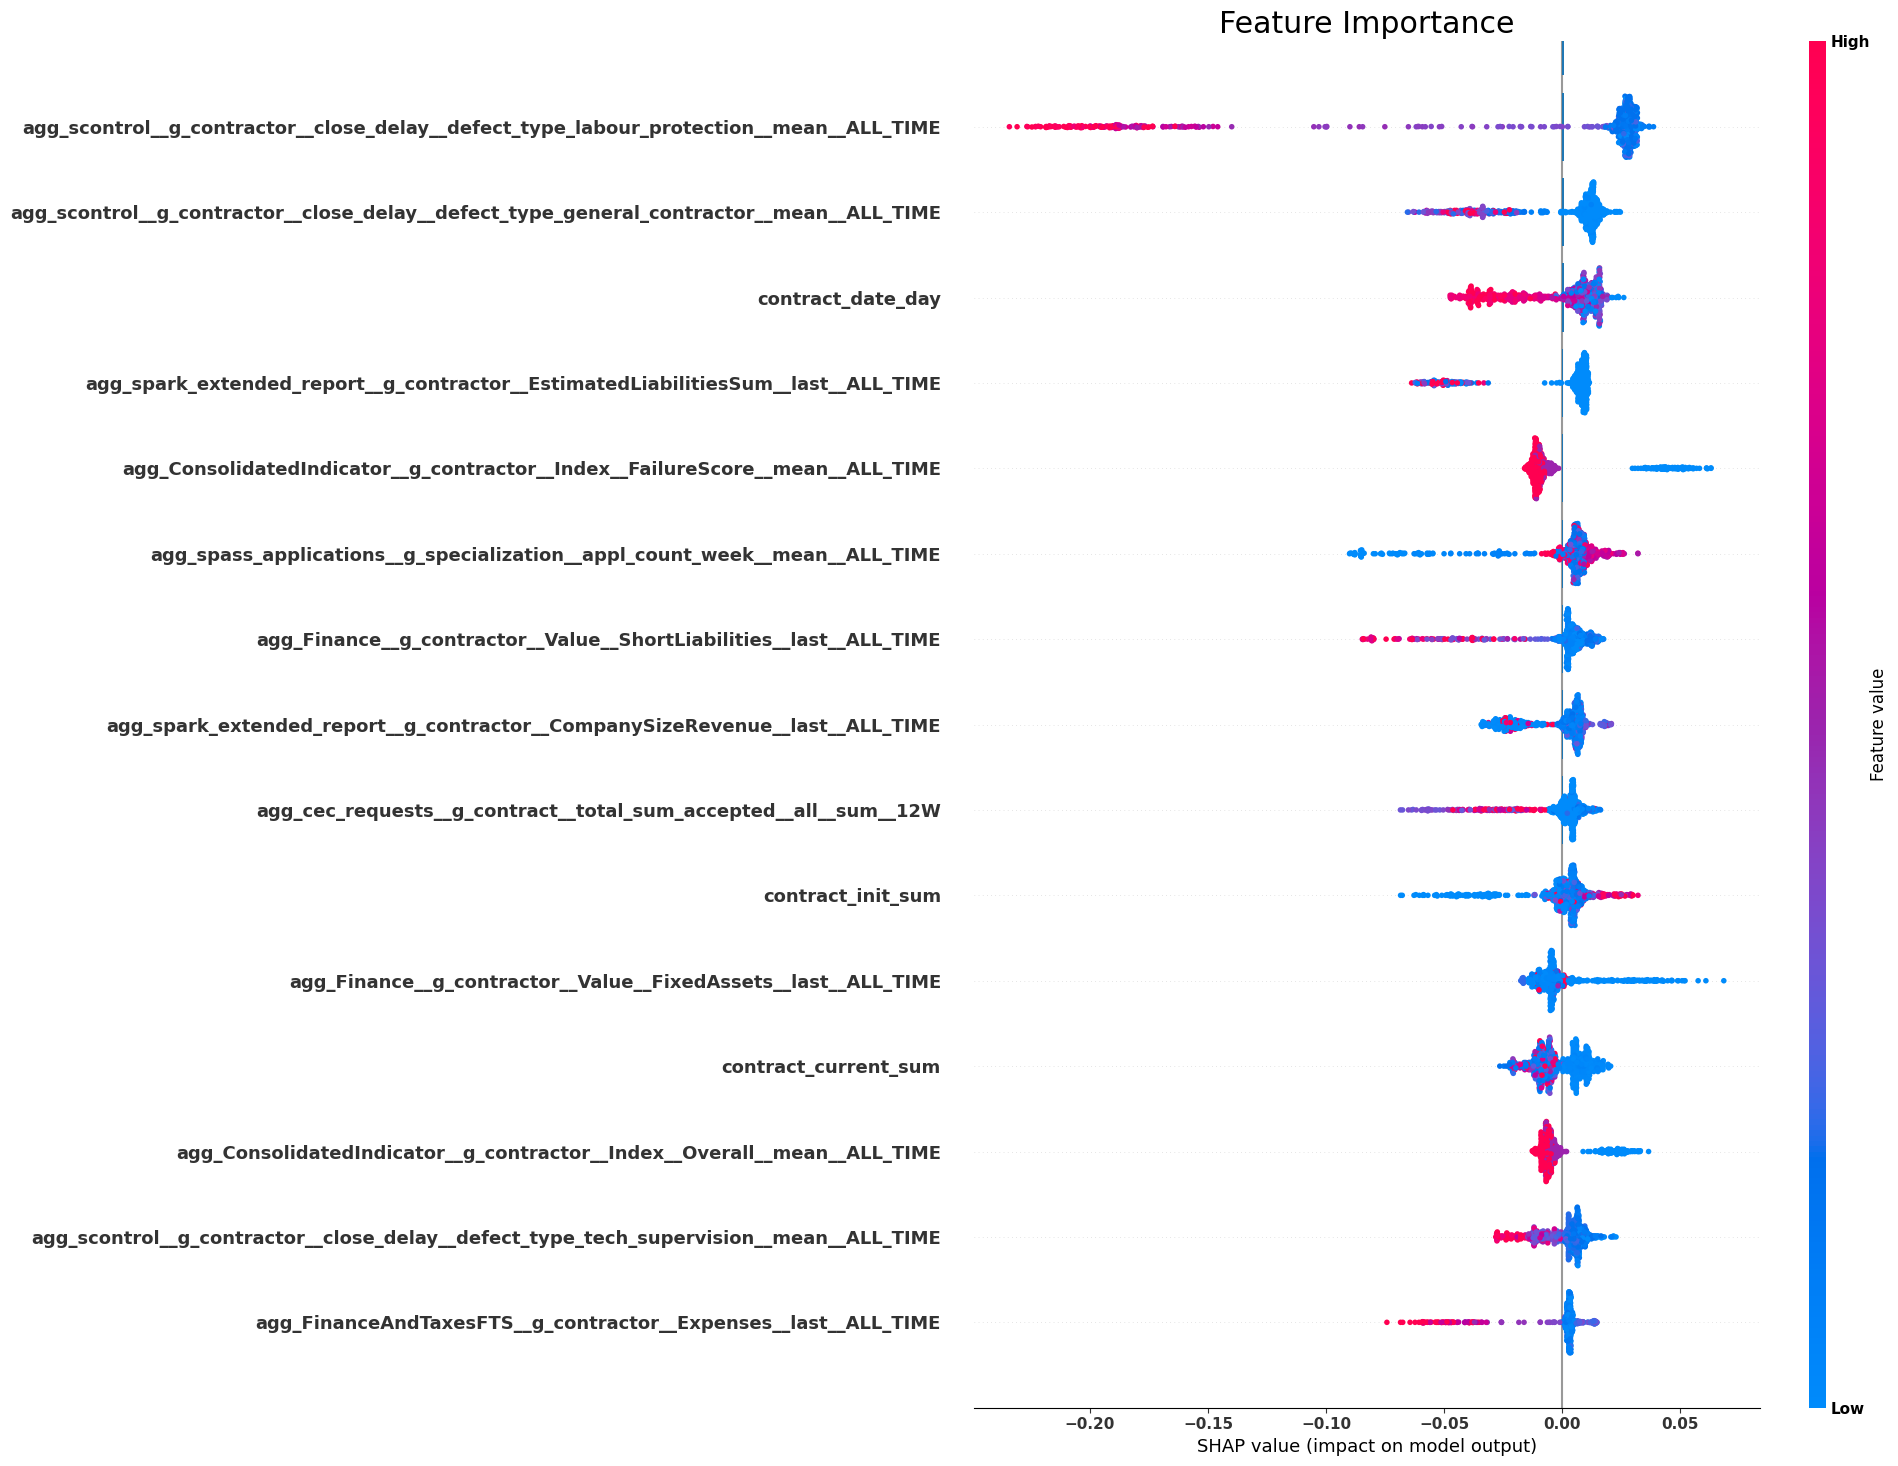

In [ ]:
X_train["new_target"] = 0
X_val["new_target"] = 1
train_test = pd.concat(
    [X_train, X_val],
    axis=0
).reset_index(drop=True)
contract_ids = train_test["contract_id"].unique()
train_idxs = np.random.choice(contract_ids, size=(int(len(contract_ids) * 0.8)))
val_idxs = [idx for idx in contract_ids if idx not in train_idxs]
to_drop_overfit = [
    "contract_id",
    "report_date",
    "contract_date",
    # "weight",
    "report_date_month",
    "contract_date_month",
    "report_date_day",
]
cat_train_pool = Pool(
    data=train_test[train_test.contract_id.isin(train_idxs)].drop(columns=["new_target"] + [
        "contract_id",
        "report_date",
        "contract_date",
        # "weight",
        "report_date_month",
        "contract_date_month",
        "report_date_day",
        # "kfold"
    ]),
    label=train_test[train_test.contract_id.isin(train_idxs)]['new_target'],
)
cat_valid_pool = Pool(
    data=train_test[train_test.contract_id.isin(val_idxs)].drop(columns=["new_target"] + [
        "contract_id",
        "report_date",
        "contract_date",
        # "weight",
        "report_date_month",
        "contract_date_month",
        "report_date_day",
        # "kfold"
        ]),
    label=train_test[train_test.contract_id.isin(val_idxs)]['new_target'],
)
model_params["iterations"] = 500
model_params["depth"] = 4
cat_clf = CatBoostClassifier(
    **model_params
)
cat_clf.fit(
    cat_train_pool,
    eval_set=[cat_train_pool, cat_valid_pool],
    verbose=50,
)

# clf = DecisionTreeClassifier(max_depth=4)
# clf.fit(X=train_test[train_test.contract_id.isin(train_idxs)].drop(columns=["new_target"] + [
#         "contract_id",
#         "report_date",
#         "contract_date",
#         # "weight",
#         "report_date_month",
#         "contract_date_month",
#         "report_date_day",
#         # "kfold"
#     ]), y=train_test[train_test.contract_id.isin(train_idxs)]['new_target'])

# print(sklearn.metrics.roc_auc_score(
#     train_test[train_test.contract_id.isin(train_idxs)]['new_target'],
#     clf.predict_proba(train_test[train_test.contract_id.isin(train_idxs)].drop(columns=["new_target"] + [
#         "contract_id",
#         "report_date",
#         "contract_date",
#         # "weight",
#         "report_date_month",
#         "contract_date_month",
#         "report_date_day",
#         # "kfold"
#     ]))[:, 1]
# ))
best_features_shap = select_features_with_shap(
  cat_clf,
  train_test[train_test.contract_id.isin(val_idxs)].drop(columns=["new_target"] + [
          "contract_id",
          "report_date",
          "contract_date",
          # "weight",
          "report_date_month",
          "contract_date_month",
          # "kfold",
          "report_date_day",
        ]
  ),
  k=200,
)[::-1]

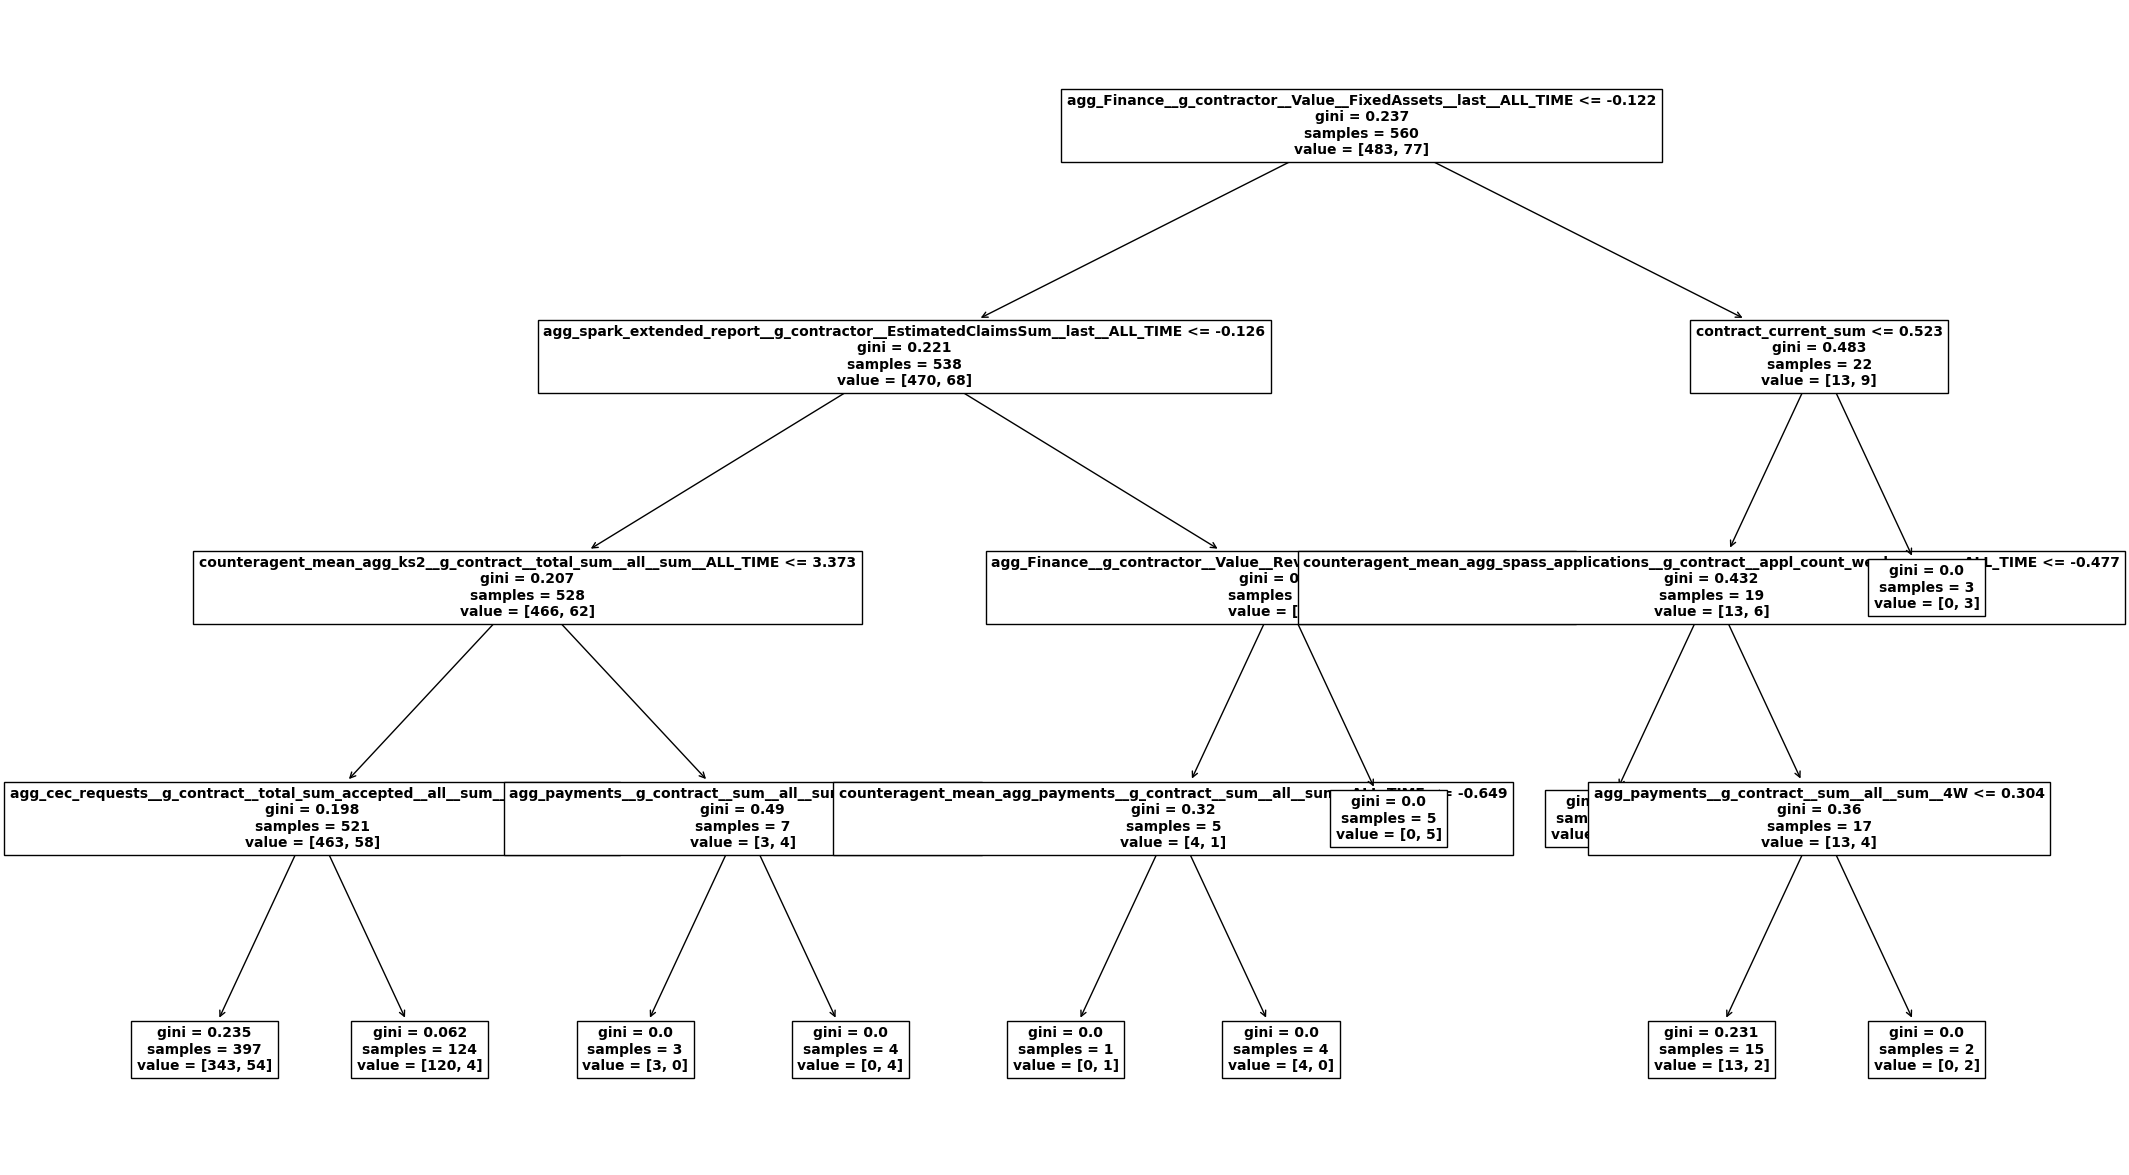

In [ ]:
plt.figure(figsize=(25,15))
sklearn.tree.plot_tree(clf, feature_names=train_test[train_test.contract_id.isin(train_idxs)].drop(columns=["new_target"] + [
        "contract_id",
        "report_date",
        "contract_date",
        # "weight",
        "report_date_month",
        "contract_date_month",
        "report_date_day",
        # "kfold"
    ]).columns, fontsize=10);

In [ ]:
# making submit for batch_training

In [189]:
contracts = test.sort_values('report_date').groupby("contract_id")

batches = [[] for i in range(contracts.size().max())]

for c_id in tqdm(test["contract_id"].unique()):
  contract = contracts.get_group(c_id).sample(frac=1).reset_index(drop=True)
  for i in range(30):
    if i >= len(contract): break
    else:
      batches[i].append(contract.loc[i])

100%|██████████| 2281/2281 [00:11<00:00, 194.20it/s]


In [155]:
for i in range(contracts.size().max()):
  print(len(batches[i]))

2281
1953
1673
1408
1222
1031
877
714
595
468
340
280
222
152


  0%|          | 0/14 [00:00<?, ?it/s]

BATCH: 1


  7%|▋         | 1/14 [00:00<00:03,  3.83it/s]

Axes(0.125,0.11;0.775x0.77)
BATCH: 2
Axes(0.125,0.11;0.775x0.77)


 21%|██▏       | 3/14 [00:00<00:02,  5.24it/s]

BATCH: 3
Axes(0.125,0.11;0.775x0.77)
BATCH: 4


 36%|███▌      | 5/14 [00:00<00:01,  6.26it/s]

Axes(0.125,0.11;0.775x0.77)
BATCH: 5
Axes(0.125,0.11;0.775x0.77)
BATCH: 6


 50%|█████     | 7/14 [00:01<00:00,  7.20it/s]

Axes(0.125,0.11;0.775x0.77)
BATCH: 7
Axes(0.125,0.11;0.775x0.77)
BATCH: 8


 64%|██████▍   | 9/14 [00:01<00:00,  8.88it/s]

Axes(0.125,0.11;0.775x0.77)
BATCH: 9
Axes(0.125,0.11;0.775x0.77)
BATCH: 10
Axes(0.125,0.11;0.775x0.77)
BATCH: 11


100%|██████████| 14/14 [00:01<00:00,  8.69it/s]

Axes(0.125,0.11;0.775x0.77)
BATCH: 12
Axes(0.125,0.11;0.775x0.77)
BATCH: 13
Axes(0.125,0.11;0.775x0.77)
BATCH: 14
Axes(0.125,0.11;0.775x0.77)


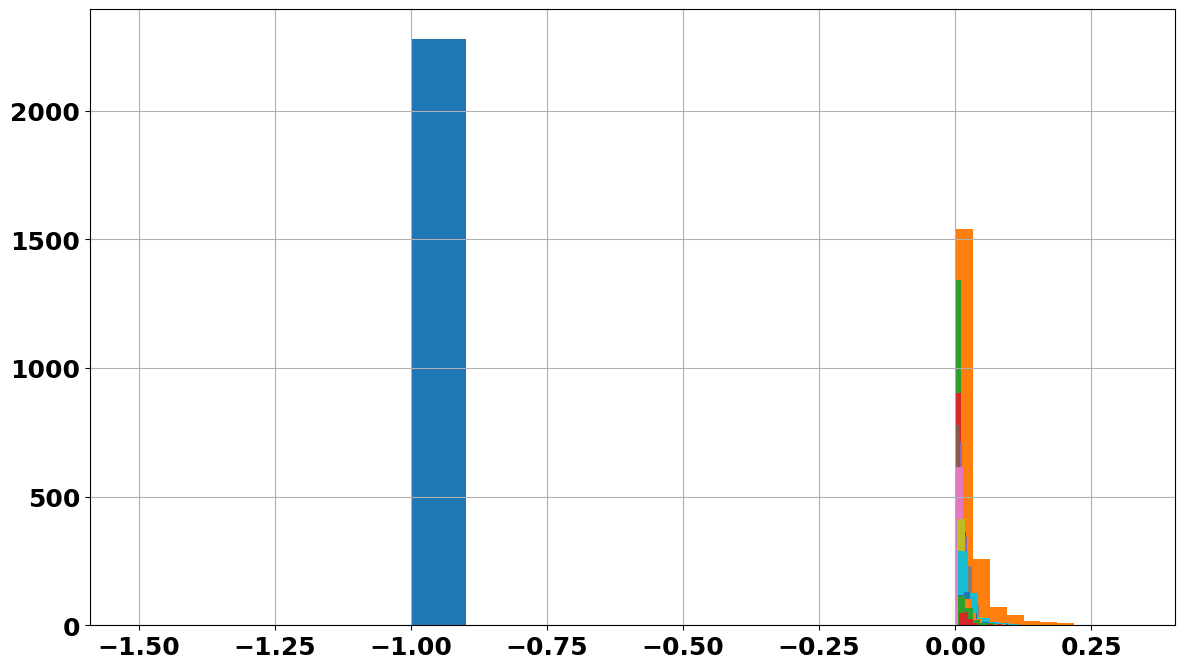

In [190]:
last_step_preds = None

preds = test[['contract_id', 'report_date']]

test_preds_df = pd.DataFrame()

for i, batch in enumerate(tqdm(batches), start=1):

  print(f"BATCH: {i}")

  batch = pd.DataFrame(batch).reset_index(drop=True)

  if last_step_preds is not None:
    batch = batch.merge(last_step_preds.rename('pred_preds'), right_index=True, left_on='contract_id', how='left')
  else:
    batch['pred_preds'] = -1

  print(batch['pred_preds'].hist())
  test_batch_pool = Pool(data=batch)
  test_batch_pool.set_baseline(cur_model.predict(test_batch_pool))

  cur_gbm = models[i]

  test_preds = cur_gbm.predict_proba(test_batch_pool)[:, 1]

  test_preds_df =  pd.concat(
      [pd.DataFrame(
        {
            'contract_id' : batch['contract_id'],
            'report_date' : batch['report_date'],
            'score' : test_preds
        }
      ),
       test_preds_df
      ]
  )

  test_preds = pd.Series(index=batch['contract_id'], data=test_preds)
  last_step_preds = test_preds
  # print(batch)
  # break

In [191]:
preds = preds.merge(
    test_preds_df,
    on=['contract_id', 'report_date'],
    how='left'
)

<Axes: >

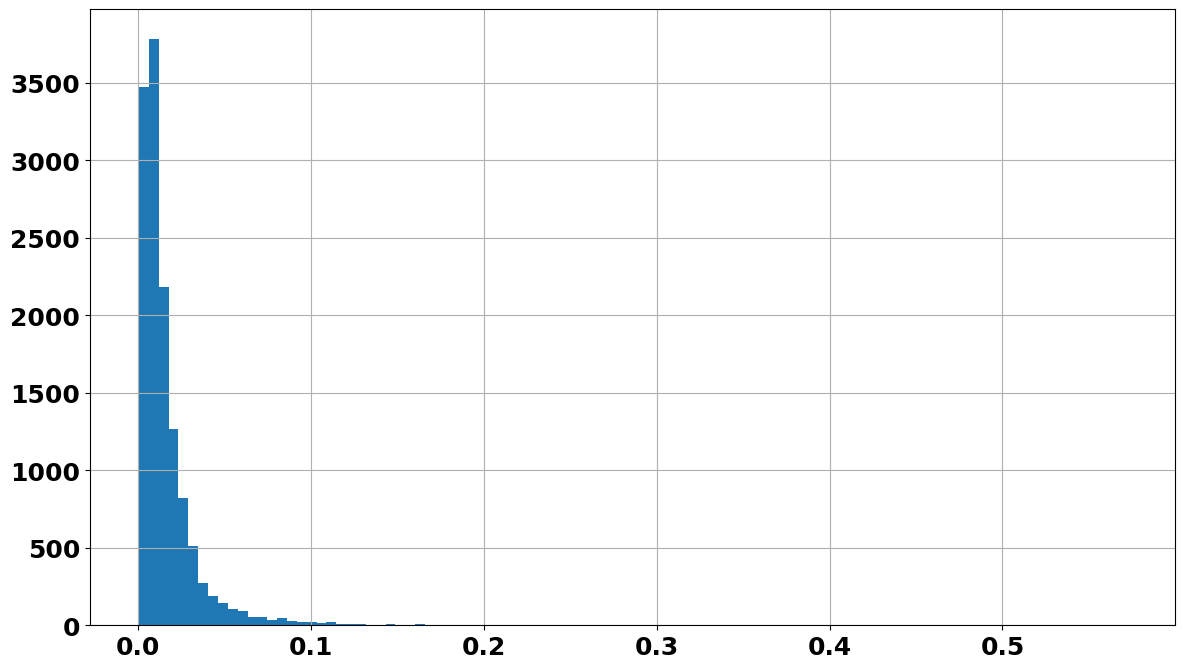

In [192]:
test_preds_df['score'].hist(bins=100)

In [193]:
sample_submit = deepcopy(test.loc[:, ["contract_id", "report_date"]])

make_res_inv = False

if make_res_inv:
  test_final_cat_preds = 1 - preds['score']

sample_submit["score"] = preds['score']

print(sample_submit.head(5))

   contract_id   report_date     score
0         3029  1.690675e+09  0.005888
1         4350  1.690675e+09  0.007930
2         1095  1.690675e+09  0.006712
3         2634  1.690675e+09  0.011166
4         6535  1.690675e+09  0.004785


<Axes: xlabel='score', ylabel='Count'>

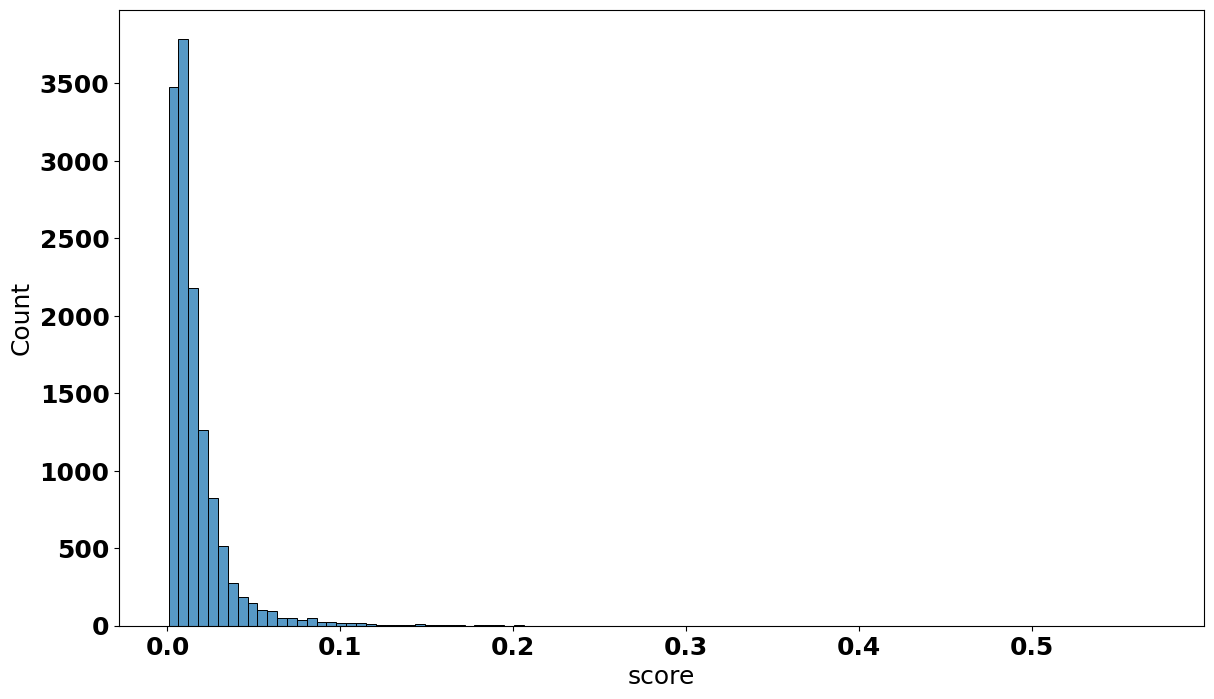

In [194]:
import math

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

sns.histplot(
    sample_submit["score"],
    bins=100
)

In [195]:
if USING_COLAB:
  subs_path = "/content/subs"
else:
  subs_path = "subs"

if not os.path.exists(subs_path):
  os.mkdir(subs_path)

# sub_name = "all_folds_default_catboost_w_feature_selection"
# sub_name = "default_catboost_with_weights_fixed_blended_new"
sub_name = "batch_training_corrected_2"
sample_submit.to_csv(f"{subs_path}/{sub_name}.csv", index=False)

In [197]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity(pd.read_csv('/content/subs/batch_training_corrected_1.csv')['score'].values.reshape(1, -1), sample_submit['score'].values.reshape(1, -1))

array([[0.68123903]])